In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load in the data set
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_data  = mnist.train.images
train_label = mnist.train.labels
test_data   = mnist.test.images
test_label  = mnist.test.labels


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
class MLP_Classifier():
    """Class that can be used to generate a dense nural net """
    def __init__(self, wd_factor, learning_rate):
        self.num_layers = 4
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.nodes_per_layer = [392.0, 196.0, 98.0, 49.0]
        
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.sess = tf.Session()
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='input')
        self.label = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='label')
        self._build_graph()
        
    def _build_graph(self):
        # Set up the graph
        with tf.variable_scope('layers'):
            h = tf.layers.dense(self.input, self.nodes_per_layer[0], kernel_initializer=tf.glorot_uniform_initializer(),
                                activation=tf.tanh, name='1', reuse=tf.AUTO_REUSE)
            print(h)
            for i in range(1, self.num_layers-1):
                h = tf.layers.dense(h, self.nodes_per_layer[i], kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name=str(i+1), reuse=tf.AUTO_REUSE)
                print(h)
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name=str(self.num_layers+1), reuse=tf.AUTO_REUSE)
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
        
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                      labels=self.label))
            self.loss += self.weight_decay()
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)   
        
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
        
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch
    

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        self.sess.run(tf.global_variables_initializer())

        print('Start Training')
        losses = []
        for i in range(iteration_steps):
            samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
            feed_dict = {self.input: samples, self.label: labels}

            _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
            if i % 50 == 0:
                print("Minibatch loss at step {}: {}".format(i, loss))
                losses.append([i, loss])
        return losses
    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        end_of_epoch = False
        losses = []
        while not end_of_epoch:
            samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
            feed_dict = {self.input: samples, self.label: labels}
            losses.append(self.sess.run(self.loss, feed_dict=feed_dict))  
        print("Average test loss: {}".format(np.mean(losses)))
            
        

In [4]:
WD_FACTOR = 0.0001
LEARNING_RATE = 0.001
model = MLP_Classifier(WD_FACTOR, LEARNING_RATE)

Tensor("layers/1/Tanh:0", shape=(?, 392), dtype=float32)
Tensor("layers/2/Tanh:0", shape=(?, 196), dtype=float32)
Tensor("layers/3/Tanh:0", shape=(?, 98), dtype=float32)
Tensor("layers/5/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_3:0", shape=(), dtype=float32)


In [5]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 2000
import time
start_time = time.time()

losses = model.train(train_data, train_label, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 2.4361629486083984
Minibatch loss at step 50: 0.3662485182285309
Minibatch loss at step 100: 0.4016081392765045
Minibatch loss at step 150: 0.41230103373527527
Minibatch loss at step 200: 0.3440922498703003
Minibatch loss at step 250: 0.31023529171943665
Minibatch loss at step 300: 0.18972395360469818
Minibatch loss at step 350: 0.48263081908226013
Minibatch loss at step 400: 0.260617196559906
Minibatch loss at step 450: 0.2231031358242035
Minibatch loss at step 500: 0.31906160712242126
Minibatch loss at step 550: 0.0984780341386795
Minibatch loss at step 600: 0.30447548627853394
Minibatch loss at step 650: 0.1862114816904068
Minibatch loss at step 700: 0.218911811709404
Minibatch loss at step 750: 0.1961979866027832
Minibatch loss at step 800: 0.1451335996389389
Minibatch loss at step 850: 0.20256191492080688
Minibatch loss at step 900: 0.19446897506713867
Minibatch loss at step 950: 0.16389957070350647
Minibatch loss at step 1000: 0.0948785692

In [6]:
losses = np.array(losses)
print(losses.shape)

(40, 2)


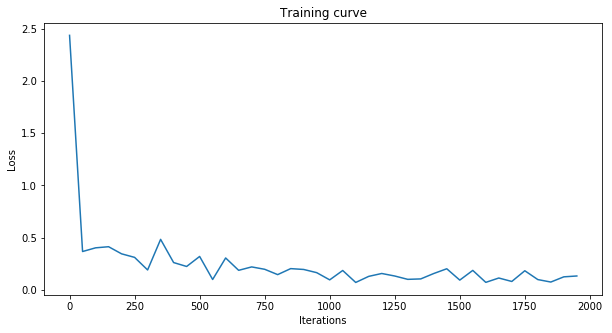

In [7]:
import matplotlib.pyplot as plt

iterations = losses[:, 0]
train_loss = losses[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

In [8]:
TEST_BATCH_SIZE = 128

model.test(test_data, test_label, TEST_BATCH_SIZE)

Average test loss: 0.13573287427425385


In [11]:
n_test = 10000
example = np.random.choice(np.arange(n_test))

sample = np.expand_dims(test_data[example], axis=0)
label = np.expand_dims(test_label[example], axis=0)

digit = np.where(label[0]==1.0)[0][0]

feed_dict = {model.input: sample, model.label: label}
prediction = model.sess.run(model.prediction, feed_dict=feed_dict)[0]

image = np.reshape(sample, (2, 32))

print("Test sample digit: {}".format(digit))
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test example")

classes = np.arange(10)
width = 1.0

#fig, ax = plt.subplots()
ax[1].bar(classes, prediction, width, color='Blue')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Network categorical distribution')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
ax[1].set_xlabel('Digit class')

plt.show()

print("Network prediction probabilities:")
print(prediction)

ValueError: cannot reshape array of size 784 into shape (32,32)